In [3]:
!pip install contractions
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow nltk gensim gradio wordcloud


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.71.0-c

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import contractions
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from gensim.models import word2vec
import gradio as gr
from tensorflow.keras.models import load_model
import pickle
from gensim.models import Word2Vec

In [46]:
import pandas as pd

hotel_df = pd.read_csv("Hotel_Reviews.csv")

In [47]:
# Initial data inspection
def dataset_overview(df, name):
    print(f"\n{name} Dataset Overview:")
    print(f"Shape: {df.shape}")
    print("\nColumns:", df.columns.tolist())
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nMissing values:", df.isnull().sum())
    if 'label' in df.columns:
        print("\nClass distribution:")
        print(df['label'].value_counts())

In [48]:
# Analyze all datasets
dataset_overview(hotel_df, "Training")


Training Dataset Overview:
Shape: (20491, 2)

Columns: ['Review', 'Rating']

First 5 rows:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5



Missing values: Review    0
Rating    0
dtype: int64


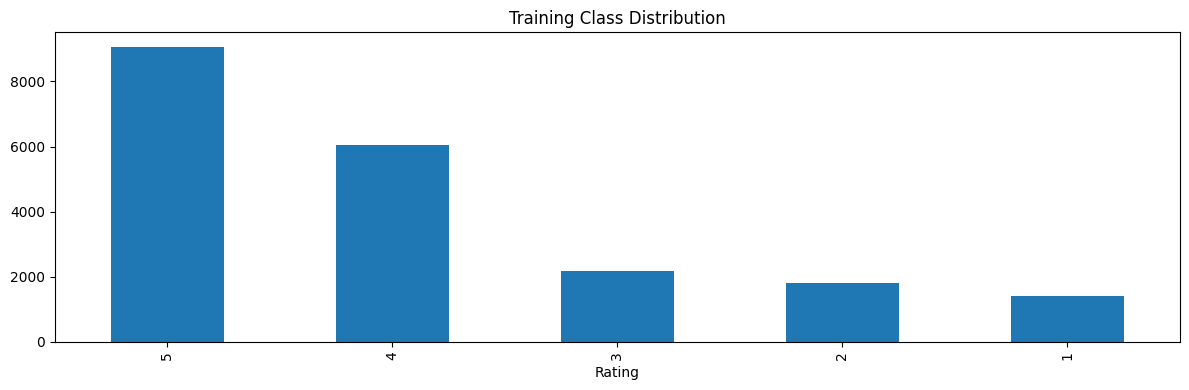

In [49]:
# Basic visualization of class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
hotel_df['Rating'].value_counts().plot(kind='bar', title='Training Class Distribution')
plt.tight_layout()
plt.show()

In [50]:
def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

In [51]:
def remove_emoji(string):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r' ', string)

In [52]:
def removeunwanted_characters(document):
  # remove user mentions
  document = re.sub("@[A-Za-z0-9_]+"," ", document)
  # remove hashtags
  document = re.sub("#[A-Za-z0-9_]+"," ", document)
  # remove punctuation
  document = re.sub("[^0-9A-Za-z ]", " " , document)
  #remove emojis
  document = remove_emoji(document)
  # Change 4* to 4
  document = re.sub(r"(\d)\*", r"\1 ", document)  # Converts 4* to 4
  # remove double spaces
  document = document.replace('  '," ")
  return document.strip()

In [53]:
import nltk
nltk.download('punkt_tab')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
negations = {"no", "not", "nor", "cannot", "never"}
custom_stopwords = stop_words - negations

def remove_stopwords(text_tokens):
    result_tokens = []
    for token in text_tokens:
        if token not in custom_stopwords:
            result_tokens.append(token)
    return result_tokens

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatization(token_text):
  wordnet = WordNetLemmatizer()
  lemmatized_tokens = [wordnet.lemmatize(token, pos = 'v') for token in token_text]

  return lemmatized_tokens

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [55]:
def expand_contractions(text):
    contraction_fixed_text = contractions.fix(text)
    return contraction_fixed_text

In [56]:
def lower_order(text):
  small_order_text = text.lower()
  return small_order_text

# Test:
sample_text = "This Is some Normalized TEXT"
sample_small = lower_order(sample_text)
print(sample_small)


this is some normalized text


In [57]:
def handle_negations(tokens, scope=2):
    negation_words = {"not", "no", "never", "neither", "nor", "n't"}
    result = []
    negate_counter = 0

    for word in tokens:
        if word in negation_words:
            result.append(word)
            negate_counter = scope
        elif negate_counter > 0:
            result.append("_NEG_" + word)
            negate_counter -= 1
        else:
            result.append(word)

    return result


In [58]:
def text_cleaning_pipeline(text, rule = "lemmatize"):
  # remove contractions
  data = expand_contractions(text)
  # Convert the input to small/lower order.
  data = lower_order(data)
  # Remove URLs
  data = remove_urls(data)
  # Remove all other unwanted characters.
  data = removeunwanted_characters(data)
  # Create tokens.
  tokens = data.split()
  # Remove stopwords:
  tokens = remove_stopwords(tokens)
  # Handle negations
  tokens = handle_negations(tokens)
  if rule == "lemmatize":
    tokens = lemmatization(tokens)
  elif rule == "stem":
    tokens = stemming(tokens)
  else:
    print("Pick between lemmatize or stem")

  return " ".join(tokens)

In [59]:
sample = "Hello @gabe_flomo 👋🏾, I still want don't us to hit that new sushi spot??? LMK when you're free cuz I can't go this or next weekend since I'll be swimming!!! #sushiBros #rawFish #🍱"
print(text_cleaning_pipeline(sample))

hello still want not _NEG_us _NEG_hit new sushi spot lmk free cuz cannot go next weekend since swim


In [60]:
print(hotel_df["Review"][2])
print(hotel_df["Rating"][2])

nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 65

In [61]:
test = hotel_df["Review"][2]
print(text_cleaning_pipeline(test))

nice room not _NEG_4 _NEG_experience hotel monaco seattle good hotel n 4 level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeep staffnegatives ac unit malfunction stay desk disorganize miss 3 separate wakeup call concierge busy hard touch n provide guidance special request tv hard use ipod sound dock suite non function decide book mediterranean suite 3 night weekend stay 1st choice rest party fill comparison w spend 45 night larger square footage room great soak tub whirlpool jet nice shower stay hotel arrange car service price 53 tip reasonable driver wait arrival checkin easy downside room pick 2 person jacuzi tub no _NEG_bath _NEG_accessories salt bubble bath n stay night get 12 1a check voucher bottle champagne nice gesture fish wait room impression room huge open space felt room big tv far away bed chore change channel ipod dock break disappoint morning way ask desk check thermostat say 65f 74 2 degrees warm try cover face night bright blue l

In [62]:
hotel_df['cleaned_text'] = hotel_df['Review'].apply(lambda dataset: text_cleaning_pipeline(dataset))

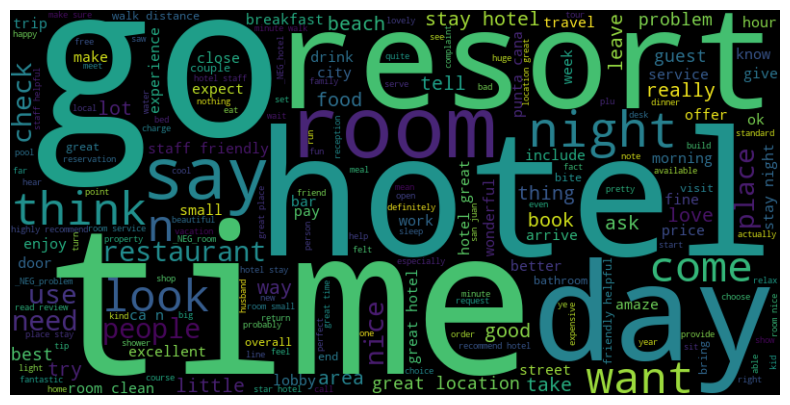

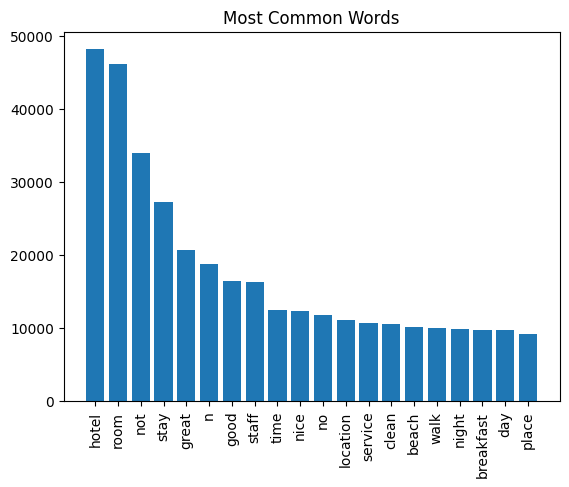

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

all_words = ' '.join(hotel_df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400).generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

word_freq = Counter(all_words.split())
common_words = word_freq.most_common(20)

plt.bar(*zip(*common_words))
plt.title('Most Common Words')
plt.xticks(rotation=90)
plt.show()

In [64]:
print(hotel_df.columns)

Index(['Review', 'Rating', 'cleaned_text'], dtype='object')


In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X = hotel_df['cleaned_text'].values
y = hotel_df['Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tokenizer = Tokenizer(oov_token="<OOV>", num_words=20000)
tokenizer.fit_on_texts(X_train)

vocab_size =20000

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Percentile-based padding
lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Now use to_categorical
y_train_encoded = to_categorical(y_train_enc)
y_test_encoded = to_categorical(y_test_enc)

In [76]:
print(label_encoder.classes_)


[1 2 3 4 5]


In [66]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights_dict = dict(enumerate(class_weights))

In [77]:
print(X_train_pad)

[[  40    3    7 ...    0    0    0]
 [1667   29 3660 ...    0    0    0]
 [  40  228    4 ...    0    0    0]
 ...
 [   5    2  525 ...    0    0    0]
 [   9   87  114 ...    0    0    0]
 [ 525    4    7 ...    0    0    0]]


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    
    SimpleRNN(128, return_sequences=True),
    Dropout(0.3),
    
    SimpleRNN(64, return_sequences=True),
    Dropout(0.3),

    SimpleRNN(32),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model1.fit(
    X_train_pad, 
    y_train_encoded, 
    validation_data=(X_test_pad, y_test_encoded), 
    epochs=10, 
    batch_size=32, 
    class_weight=class_weights_dict, 
    callbacks=[early_stop]
)


C:\Users\adity\anaconda3\envs\python_10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 64s 124ms/step - accuracy: 0.2417 - loss: 1.5846 - val_accuracy: 0.2269 - val_loss: 1.6094
Epoch 2/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.2714 - loss: 1.5845 - val_accuracy: 0.2283 - val_loss: 1.5896
Epoch 3/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.2779 - loss: 1.5710 - val_accuracy: 0.2162 - val_loss: 1.6247
Epoch 4/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 66s 128ms/step - accuracy: 0.2787 - loss: 1.5553 - val_accuracy: 0.3093 - val_loss: 1.5905
Epoch 5/10
513/513 ━━━━━━━━━━━━━━━━━━━━ 65s 127ms/step - accuracy: 0.2897 - loss: 1.5304 - val_accuracy: 0.2952 - val_loss: 1.6171


In [68]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model2.add(LSTM(units=64, return_sequences=False))
model2.add(Dense(units=y_train_encoded.shape[1], activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.build(input_shape=(None, 200))
model2.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 200, 128)       │     5,360,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409,861 (20.64 MB)

 Trainable params: 5,409,861 (20.64 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
embedding_dim = 300

# Prepare tokenized text corpus
tokenized_text = [text.split() for text in hotel_df['cleaned_text']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=embedding_dim, window=5, min_count=1)

# Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     input_length=max_len,
                     weights=[embedding_matrix],
                     trainable=False))  # freeze embeddings
model3.add(LSTM(units=64, return_sequences=False))
model3.add(Dense(units=y_train_encoded.shape[1], activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.build(input_shape=(None, 200))
model3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 200, 300)       │    12,562,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,656,565 (48.28 MB)

 Trainable params: 93,765 (366.27 KB)

 Non-trainable params: 12,562,800 (47.92 MB)

In [70]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model1.fit(X_train_pad, y_train_encoded, 
          validation_data=(X_test_pad, y_test_encoded), 
          epochs=10, 
          batch_size=64,
          class_weight=class_weights_dict,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.2415 - loss: 1.5673 - val_accuracy: 0.2013 - val_loss: 1.6076
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 123ms/step - accuracy: 0.2544 - loss: 1.5719 - val_accuracy: 0.1747 - val_loss: 1.6096
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.2285 - loss: 1.5758 - val_accuracy: 0.2684 - val_loss: 1.6368
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.2470 - loss: 1.6073 - val_accuracy: 0.3415 - val_loss: 1.6061
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.2404 - loss: 1.5897 - val_accuracy: 0.3669 - val_loss: 1.5936
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 124ms/step - accuracy: 0.2564 - loss: 1.5895 - val_accuracy: 0.2264 - val_loss: 1.5778
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.2353 - loss: 1.5798 - val_accuracy: 0.3089 - val_loss: 1.5956
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 32s 126ms/step - accuracy: 0.2647 - loss: 1

In [71]:
# Train Model 2
history2 = model2.fit(
    train_padded, hotel_df['sentiment'],
    validation_data=(val_padded, val_df['sentiment']),
    epochs=20, callbacks=[es]
)

NameError: name 'train_padded' is not defined

In [ ]:
# Train Model 3
history3 = model3.fit(
    train_padded, hotel_df['sentiment'],
    validation_data=(val_padded, val_df['sentiment']),
    epochs=20, callbacks=[es]
)

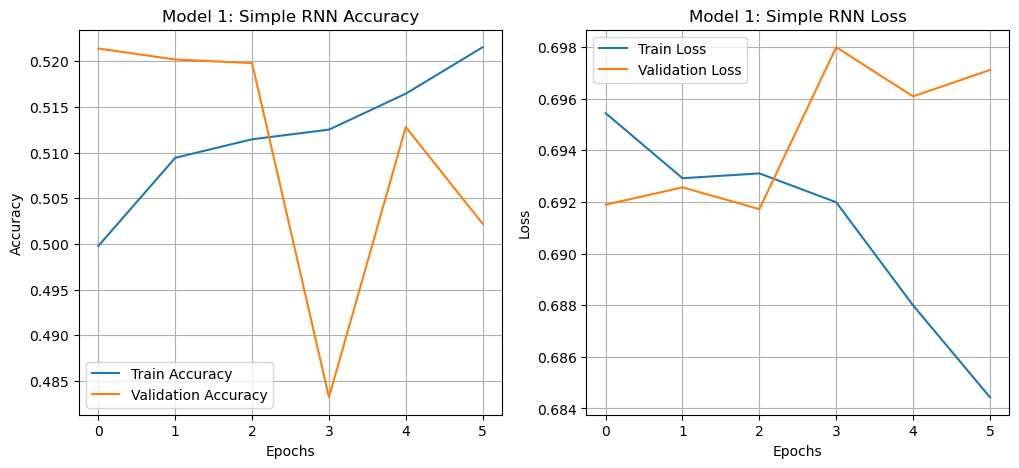

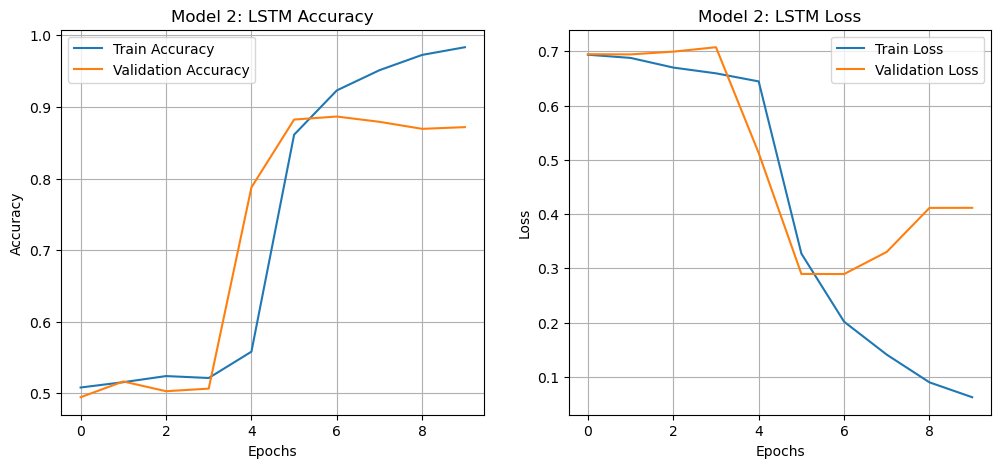

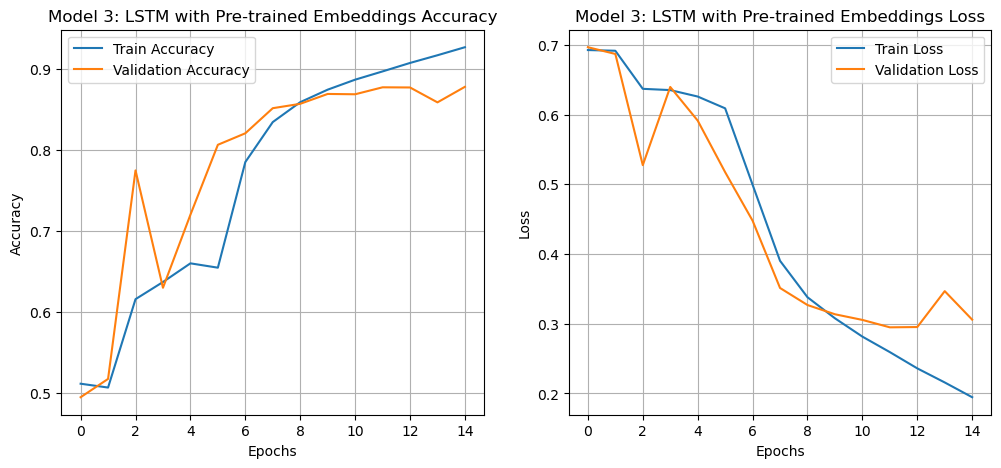

In [29]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()

# Plot history for model1
plot_history(history1, 'Model 1: Simple RNN')

# Plot history for model2
plot_history(history2, 'Model 2: LSTM')

# Plot history for model3
plot_history(history3, 'Model 3: LSTM with Pre-trained Embeddings')

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Function to evaluate a model
def evaluate_model(model, test_data, true_labels, model_name):
    loss, accuracy = model.evaluate(test_data, true_labels)
    print(f'{model_name} Test Accuracy: {accuracy * 100:.2f}%')
    
    y_pred = (model.predict(test_data) > 0.5).astype(int)
    
    print(f'\n{model_name} Confusion Matrix:')
    print(confusion_matrix(true_labels, y_pred))
    
    print(f'\n{model_name} Classification Report:')
    print(classification_report(true_labels, y_pred))

# Evaluate all models
evaluate_model(model1, test_padded, test_df['sentiment'], 'Model 1: Simple RNN')
print("-------------------------------------------------------------------------------------------------")
evaluate_model(model2, test_padded, test_df['sentiment'], 'Model 2: LSTM')
print("-------------------------------------------------------------------------------------------------")
evaluate_model(model3, test_padded, test_df['sentiment'], 'Model 3: LSTM with Pre-trained Embeddings')
print("-------------------------------------------------------------------------------------------------")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5066 - loss: 0.6934
Model 1: Simple RNN Test Accuracy: 51.31%
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Model 1: Simple RNN Confusion Matrix:
[[1212 3749]
 [1120 3919]]

Model 1: Simple RNN Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.24      0.33      4961
           1       0.51      0.78      0.62      5039

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.47     10000
weighted avg       0.52      0.51      0.48     10000

-------------------------------------------------------------------------------------------------
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8786 - loss: 0.2940
Model 2: LSTM Test Accuracy: 88.12%
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step

Model 2: LSTM Confusion Matrix:
[[4234  727]
 [ 461 4578]]

Model 2: LSTM Classification Report:
              precision    recall  f1-score   support

In [35]:
model1.save("model_rnn.keras")
model2.save("model_lstm.keras")
model3.save("model_lstm_w2v.keras")

In [38]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("maxlen.pkl", "wb") as f:
    pickle.dump(maxlen, f)


In [39]:
import os
print(os.getcwd())

C:\Users\raipr\Downloads\TASK 2


In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class SentimentAnalyzerApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Movie Review Sentiment Analyzer")
        
        # Load resources
        self.load_resources()
        
        # Create GUI components
        self.create_widgets()
    
    def load_resources(self):
        # Load tokenizer and maxlen
        with open("tokenizer.pkl", "rb") as f:
            self.tokenizer = pickle.load(f)
        with open("maxlen.pkl", "rb") as f:
            self.maxlen = pickle.load(f)
        
        # Load models
        self.models = {
            "Simple RNN": load_model("model_rnn.keras"),
            "LSTM": load_model("model_lstm.keras"),
            "LSTM with Word2Vec": load_model("model_lstm_w2v.keras")
        }
        
        # Initialize text cleaning components
        self.contractions_dict = {
            "ain't": "am not", "aren't": "are not", "can't": "cannot",
            # Add more contractions as needed
        }
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        # Text cleaning implementation (same as training)
        text = text.lower()
        text = re.sub(r'http\S+|@\w+|#\w+|\d+|[^a-zA-Z\s]', '', text)
        text = self.expand_contractions(text)
        tokens = word_tokenize(text)
        clean_tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in self.stop_words]
        return ' '.join(clean_tokens)
    
    def expand_contractions(self, text):
        contractions_re = re.compile('(%s)' % '|'.join(self.contractions_dict.keys()))
        def replace(match):
            return self.contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)
    
    def predict_sentiment(self):
        review = self.text_input.get("1.0", "end-1c")
        if not review.strip():
            messagebox.showwarning("Input Error", "Please enter a review!")
            return
        
        # Clean and preprocess the text
        clean_review = self.clean_text(review)
        sequence = self.tokenizer.texts_to_sequences([clean_review])
        padded = pad_sequences(sequence, maxlen=self.maxlen, padding='post')
        
        # Get selected model
        model_name = self.model_var.get()
        model = self.models[model_name]
        
        # Make prediction
        prediction = model.predict(padded)
        confidence = prediction[0][0]
        sentiment = "Positive" if confidence > 0.5 else "Negative"
        confidence_percent = confidence * 100 if sentiment == "Positive" else (1 - confidence) * 100
        
        # Update result
        self.result_var.set(f"Sentiment: {sentiment} ({confidence_percent:.1f}% confident)")

    def create_widgets(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding=20)
        main_frame.grid(row=0, column=0, sticky="nsew")
        
        # Text input
        ttk.Label(main_frame, text="Enter Movie Review:").grid(row=0, column=0, sticky="w")
        self.text_input = tk.Text(main_frame, width=60, height=10, wrap="word")
        self.text_input.grid(row=1, column=0, columnspan=2, pady=5)
        
        # Model selection
        ttk.Label(main_frame, text="Select Model:").grid(row=2, column=0, sticky="w", pady=5)
        self.model_var = tk.StringVar()
        self.model_dropdown = ttk.Combobox(main_frame, textvariable=self.model_var, 
                                         values=list(self.models.keys()), state="readonly")
        self.model_dropdown.current(1)
        self.model_dropdown.grid(row=2, column=1, sticky="ew", pady=5)
        
        # Predict button
        predict_btn = ttk.Button(main_frame, text="Analyze Sentiment", command=self.predict_sentiment)
        predict_btn.grid(row=3, column=0, columnspan=2, pady=10)
        
        # Result display
        self.result_var = tk.StringVar()
        result_lbl = ttk.Label(main_frame, textvariable=self.result_var, 
                             font=('Helvetica', 12, 'bold'), foreground="blue")
        result_lbl.grid(row=4, column=0, columnspan=2, pady=10)
        
        # Configure grid weights
        main_frame.columnconfigure(1, weight=1)
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)

if __name__ == "__main__":
    root = tk.Tk()
    app = SentimentAnalyzerApp(root)
    root.mainloop()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raipr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
